In [2]:
import pickle as pkl
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os
import numpy as np
from matplotlib.ticker import MaxNLocator

class_names = ["VEHICLE", "PEDESTRIAN", "CYCLIST"]


In [3]:
#Functions

def load_baseline(baseline_folder, log_file_idx=0):
    #load baseline
    #baseline_folder = "/home/cgriesbacher/thesis/3DTrans/output/avltruck_models/pvrcnnpp_ros/D6_50epochs/eval/epoch_50/val/zod"

    #log_file_idx = 0           #the selected eval is the first log file


    #get all files that start with "log"
    files = [f.path for f in os.scandir(baseline_folder) if f.name.startswith("log") ]
    files.sort()

    #select correct log file
    file = files[log_file_idx]

    with open(file) as f:
        lines = f.readlines()

    #get liens that start with any string in classes
    lines = [line for line in lines if line.startswith(tuple(class_names))]
    #check if there are any lines, if not, skip this file
    if len(lines) == 0:
        print("No lines starting with classes found, skipping file")

    #strip the lines
    lines = [line.strip() for line in lines]
    #remove the "\n"
    lines = [line.replace("\n", "") for line in lines]
    #split by ":" and keep second part
    values = [line.split(":")[1] for line in lines]
    #cast to float
    values = [float(line) for line in values]

    #split by "_" and keep first part
    classes = [line.split("_")[0] for line in lines]

    difficulties = [line.split("_")[1] for line in lines]
    #split by "/" and keep first part
    difficulties = [line.split("/")[0] for line in difficulties]

    metrics = [line.split("/")[1] for line in lines]
    metrics = [line.split(":")[0] for line in metrics]

    #convert to dataframe
    baseline_df = pd.DataFrame({"class": classes, "difficulty": difficulties, "metric": metrics, "value": values})

    return baseline_df

def load_data(filepath):

    with open(filepath) as f:
        lines = f.readlines()

    #get liens that start with any string in classes
    lines = [line for line in lines if line.startswith(tuple(class_names))]
    #check if there are any lines, if not, skip this file
    if len(lines) == 0:
        print("No lines starting with classes found, skipping file")

    #strip the lines
    lines = [line.strip() for line in lines]
    #remove the "\n"
    lines = [line.replace("\n", "") for line in lines]
    #split by ":" and keep second part
    values = [line.split(":")[1] for line in lines]
    #cast to float
    values = [float(line) for line in values]

    #split by "_" and keep first part
    classes = [line.split("_")[0] for line in lines]

    difficulties = [line.split("_")[1] for line in lines]
    #split by "/" and keep first part
    difficulties = [line.split("/")[0] for line in difficulties]

    metrics = [line.split("/")[1] for line in lines]
    metrics = [line.split(":")[0] for line in metrics]

    #convert to dataframe
    df = pd.DataFrame({"class": classes, "difficulty": difficulties, "metric": metrics, "value": values})


    return df

def plot_results(results_df, metric="AP", difficulty="2", clss="Vehicle", target_dataset="avlrooftop", draw_baseline=True, baseline_df=None, target_baseline_only=True, ax=None):

    #print difficutly 2 performance for each class
    results_df = results_df[results_df["difficulty"] == difficulty]
    results_df = results_df[results_df["metric"] == metric]
    results_df = results_df[results_df["class"] == clss]

    plot_df = results_df[results_df["target_dataset"] == target_dataset]


    #if ax is not given, create new figure
    if ax is None:
        plt.figure(figsize=(15, 8), dpi=150)
        sns.set_theme(style="whitegrid")
        ax = plt.gca()

    sns.lineplot(data=plot_df, x="exp_number", y="value", hue="source_dataset", ax=ax)
    #plt.xticks(results_df["exp_number"].unique())
    ax.set_title(clss)
    ax.set_ylabel(metric+"/L"+difficulty,)
    ax.set_xlabel("Datasplit in percent")


    #add minor grid
    ax.grid(b=True, which='minor', linestyle='--', alpha=0.2)
    ax.minorticks_on()

    if draw_baseline and len(baseline_df) > 0:
        if target_baseline_only:
            baseline_df = baseline_df[(baseline_df["source_dataset"] == target_dataset) & (baseline_df["target_dataset"] == target_dataset)]
        #add hline
        baseline_target_df = baseline_df[(baseline_df["class"] == clss) & 
                                         (baseline_df["difficulty"] == difficulty) & 
                                         (baseline_df["metric"] == metric) &
                                         (baseline_df["target_dataset"] == target_dataset)]
        for i, source_dataste in enumerate(baseline_target_df["source_dataset"].unique()):
            baseline_value = baseline_target_df[baseline_target_df["source_dataset"] == source_dataste]["value"].values[0]
            ax.axhline(y=baseline_value, linestyle='-', label=source_dataste + " target only", ls="--", color=sns.color_palette()[i])


    #add legend outside of plot
    ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    #plt.show()
        
    #return axis
    return ax

def find_subfolder(parent_folder, subfolder_name):
    # Iterate through all directories and subdirectories in the parent_folder
    for root, dirs, files in os.walk(parent_folder):
        # Check if the subfolder_name exists in the current directory's subdirectories
        if subfolder_name in dirs:
            # If found, return the full path of the subfolder
            return os.path.join(root, subfolder_name)
    # If the subfolder_name is not found, return None
    return None


In [10]:
#load baseline
baseline_folder = "/home/cgriesbacher/thesis/3DTrans/output/zod_models/pvrcnnpp/D16_50epochs/eval/epoch_50/val/avltruck"

# fewshot names experiment names
exp_names = ["0.1%", "0.2%", "0.5%", "1%","2%","5%","10%", "20%", "50%"]
#exp_names = ["0.1%", "0.2%", "0.5%", "2%","5%","10%", "20%", "50%"]
exp_numbers = [0.1, 0.2, 0.5, 1, 2, 5, 10, 20, 50]
#exp_numbers = [0.1, 0.2, 0.5, 2, 5, 10, 20, 50]
dataset_names = ["avltruck", "avlrooftop", "zod"]
source_dataset_fileexts = ["D6_50epochs", "D1_50epochs", "D16_50epochs"]

target_dataset_subsample_factors = [
["D6000", "D1000", "D16000"],
["D3000", "D500", "D8000"],
["D1200", "D200", "D3200"],
["D600", "D100", "D1600"],
["D300", "D50", "D800"],
["D120", "D20", "D320"],
["D60", "D10", "D160"],
["D30", "D5", "D80"],
["D12", "D2", "D32"]
]

results_paths = [
    "/home/cgriesbacher/thesis/3DTrans/output/avltruck_models/pvrcnnpp_nogtsampling",
    "/home/cgriesbacher/thesis/3DTrans/output/avlrooftop_models/pvrcnnpp_nogtsampling",
    "/home/cgriesbacher/thesis/3DTrans/output/zod_models/pvrcnnpp_nogtsampling"
]
baseline_paths = [
    "/home/cgriesbacher/thesis/3DTrans/output/avltruck_models/pvrcnnpp",
    "/home/cgriesbacher/thesis/3DTrans/output/avlrooftop_models/pvrcnnpp",
    "/home/cgriesbacher/thesis/3DTrans/output/zod_models/pvrcnnpp"
]
#results df
results_df = pd.DataFrame()
baseline_df = pd.DataFrame()
#load baselines
for source_dataset_i, source_dataset in enumerate(dataset_names):
    for target_dataset_i, target_dataset in enumerate(dataset_names):
        source_dataset_fileext = source_dataset_fileexts[source_dataset_i]
        baseline_folder = baseline_paths[source_dataset_i]+"/"+source_dataset_fileext+"/eval/epoch_50/val/"+target_dataset
        df = load_baseline(baseline_folder)
        df["target_dataset"] = target_dataset
        df["source_dataset"] = source_dataset
        baseline_df = pd.concat([baseline_df, df])

    
#add baselines to results_df
baseline_df["exp_name"] = "0%"
baseline_df["exp_number"] = 0
results_df = pd.concat([results_df, baseline_df])

for exp_i, exp_name in enumerate(exp_names):
    exp_number = exp_numbers[exp_i]
    for target_dataset_i, target_dataset in enumerate(dataset_names):
        results_path = results_paths[target_dataset_i]
        target_subsample_factor = target_dataset_subsample_factors[exp_i][target_dataset_i]
    
        for source_dataset_i, source_dataset in enumerate(dataset_names):
            if target_dataset == source_dataset:
                continue

            source_dataset_fileext = source_dataset_fileexts[source_dataset_i]
            
            exp_folder = results_path+ "/" + target_subsample_factor + "_50epochs_ft_"+source_dataset_fileext
            exp_filepath = exp_folder + "/eval/epoch_50/val/"+target_dataset
            print(exp_filepath)
            #find all files in folder
            files = [f.path for f in os.scandir(exp_filepath) if f.name.startswith("log") ]
            files.sort()
            #select correct log file
            if len(files) == 0:
                print("No files found, skipping")
                continue
            file = files[0]

            df = load_data(file)
            df["exp_name"] = exp_name
            df["exp_number"] = exp_number
            df["target_dataset"] = target_dataset
            df["source_dataset"] = source_dataset

            #concat
            results_df = pd.concat([results_df, df])


results_df


/home/cgriesbacher/thesis/3DTrans/output/avltruck_models/pvrcnnpp_nogtsampling/D6000_50epochs_ft_D1_50epochs/eval/epoch_50/val/avltruck
/home/cgriesbacher/thesis/3DTrans/output/avltruck_models/pvrcnnpp_nogtsampling/D6000_50epochs_ft_D16_50epochs/eval/epoch_50/val/avltruck
/home/cgriesbacher/thesis/3DTrans/output/avlrooftop_models/pvrcnnpp_nogtsampling/D1000_50epochs_ft_D6_50epochs/eval/epoch_50/val/avlrooftop
/home/cgriesbacher/thesis/3DTrans/output/avlrooftop_models/pvrcnnpp_nogtsampling/D1000_50epochs_ft_D16_50epochs/eval/epoch_50/val/avlrooftop
/home/cgriesbacher/thesis/3DTrans/output/zod_models/pvrcnnpp_nogtsampling/D16000_50epochs_ft_D6_50epochs/eval/epoch_50/val/zod
/home/cgriesbacher/thesis/3DTrans/output/zod_models/pvrcnnpp_nogtsampling/D16000_50epochs_ft_D1_50epochs/eval/epoch_50/val/zod
/home/cgriesbacher/thesis/3DTrans/output/avltruck_models/pvrcnnpp_nogtsampling/D3000_50epochs_ft_D1_50epochs/eval/epoch_50/val/avltruck
/home/cgriesbacher/thesis/3DTrans/output/avltruck_models

,class,difficulty,metric,value,target_dataset,source_dataset,exp_name,exp_number
0,VEHICLE,1,AP,67.8706,avltruck,avltruck,0%,0.0
1,VEHICLE,2,AP,63.1544,avltruck,avltruck,0%,0.0
2,PEDESTRIAN,1,AP,50.0333,avltruck,avltruck,0%,0.0
3,PEDESTRIAN,2,AP,45.7885,avltruck,avltruck,0%,0.0
4,CYCLIST,1,AP,69.5202,avltruck,avltruck,0%,0.0
...,...,...,...,...,...,...,...,...
1,VEHICLE,2,AP,66.9065,zod,avlrooftop,50%,50.0
2,PEDESTRIAN,1,AP,52.5873,zod,avlrooftop,50%,50.0
3,PEDESTRIAN,2,AP,49.5244,zod,avlrooftop,50%,50.0
4,CYCLIST,1,AP,62.7120,zod,avlrooftop,50%,50.0


/tmp/ipykernel_394494/1426146130.py:110: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b=True, which='minor', linestyle='--', alpha=0.2)
/tmp/ipykernel_394494/1426146130.py:110: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b=True, which='minor', linestyle='--', alpha=0.2)
/tmp/ipykernel_394494/1426146130.py:110: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b=True, which='minor', linestyle='--', alpha=0.2)


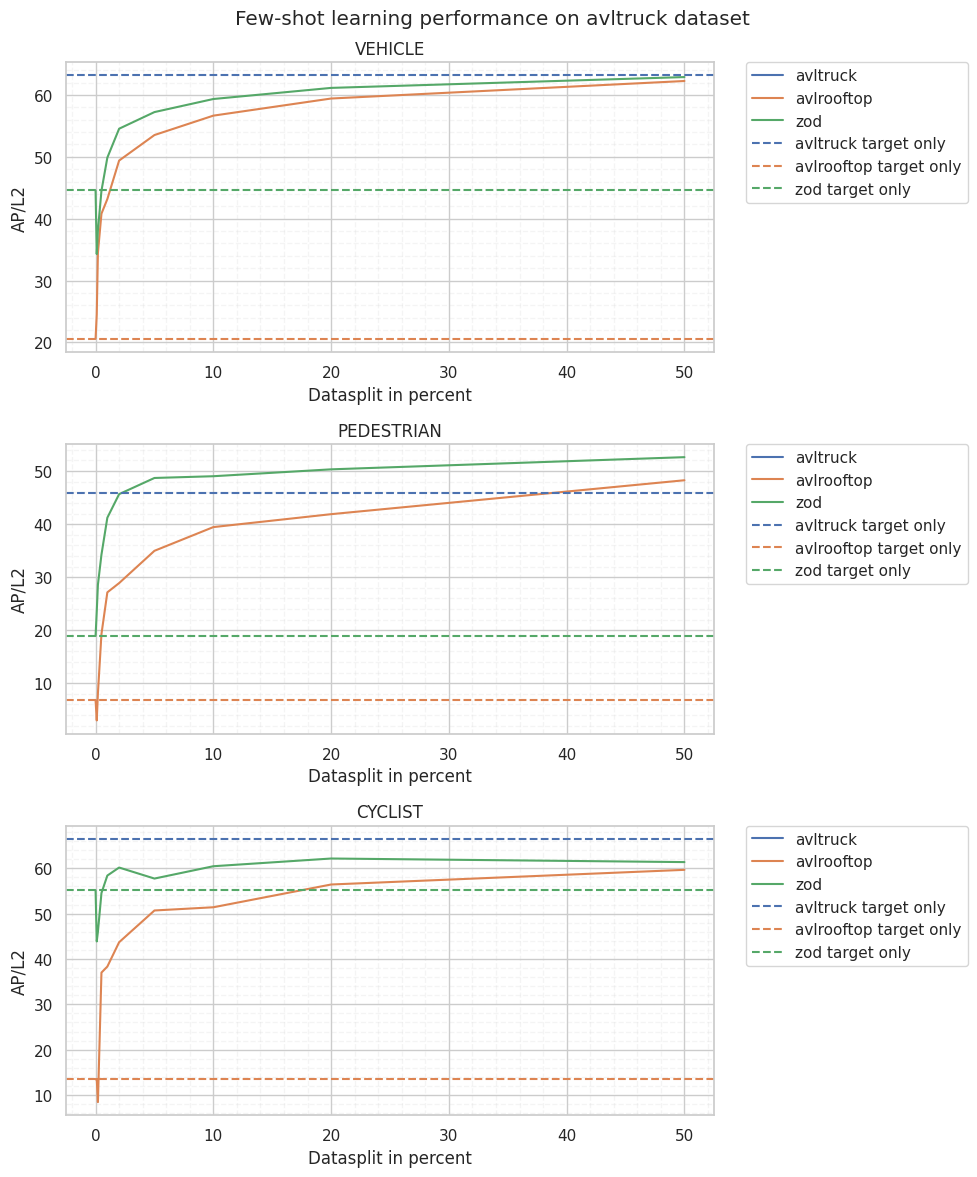

/tmp/ipykernel_394494/1426146130.py:110: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b=True, which='minor', linestyle='--', alpha=0.2)
/tmp/ipykernel_394494/1426146130.py:110: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b=True, which='minor', linestyle='--', alpha=0.2)
/tmp/ipykernel_394494/1426146130.py:110: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b=True, which='minor', linestyle='--', alpha=0.2)


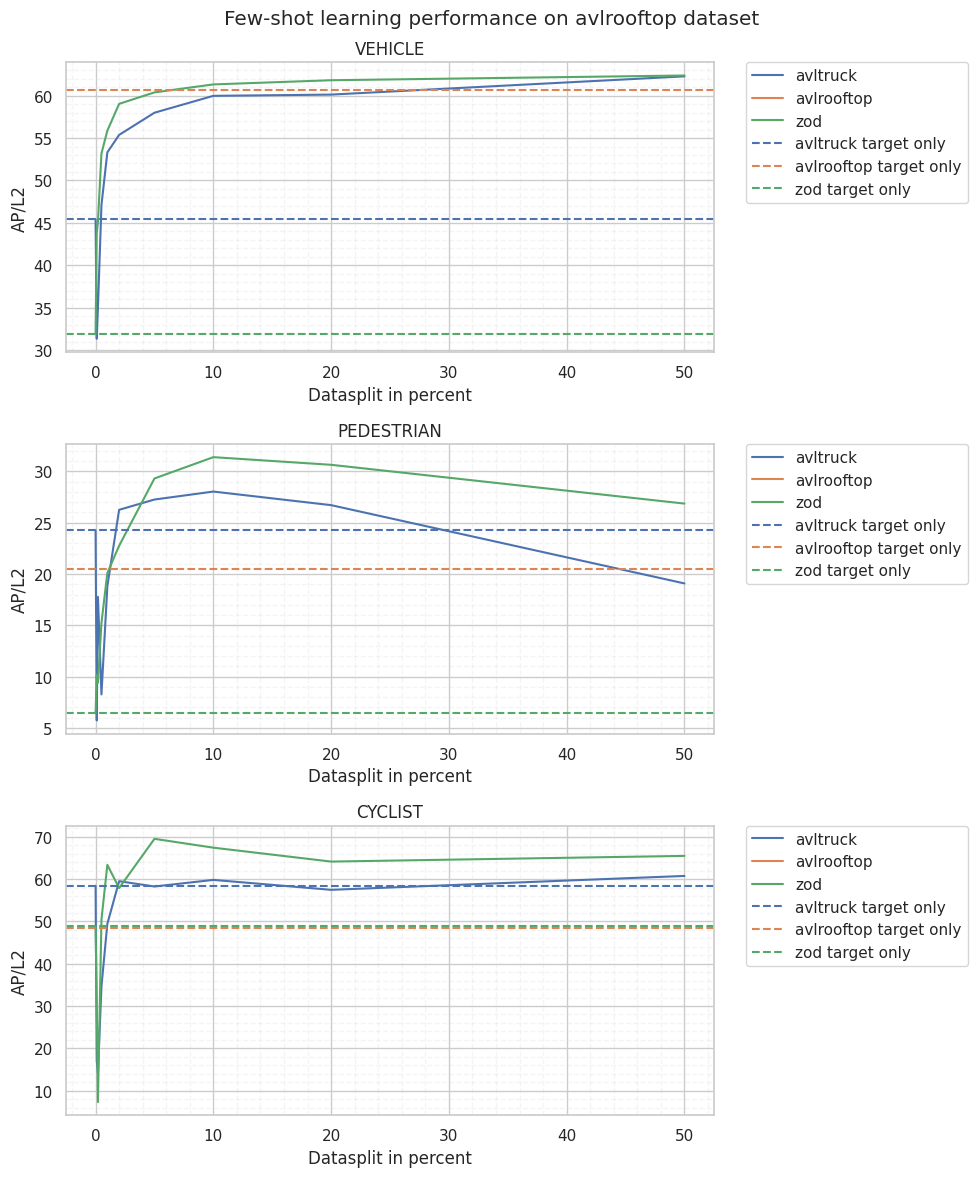

/tmp/ipykernel_394494/1426146130.py:110: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b=True, which='minor', linestyle='--', alpha=0.2)
/tmp/ipykernel_394494/1426146130.py:110: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b=True, which='minor', linestyle='--', alpha=0.2)
/tmp/ipykernel_394494/1426146130.py:110: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b=True, which='minor', linestyle='--', alpha=0.2)


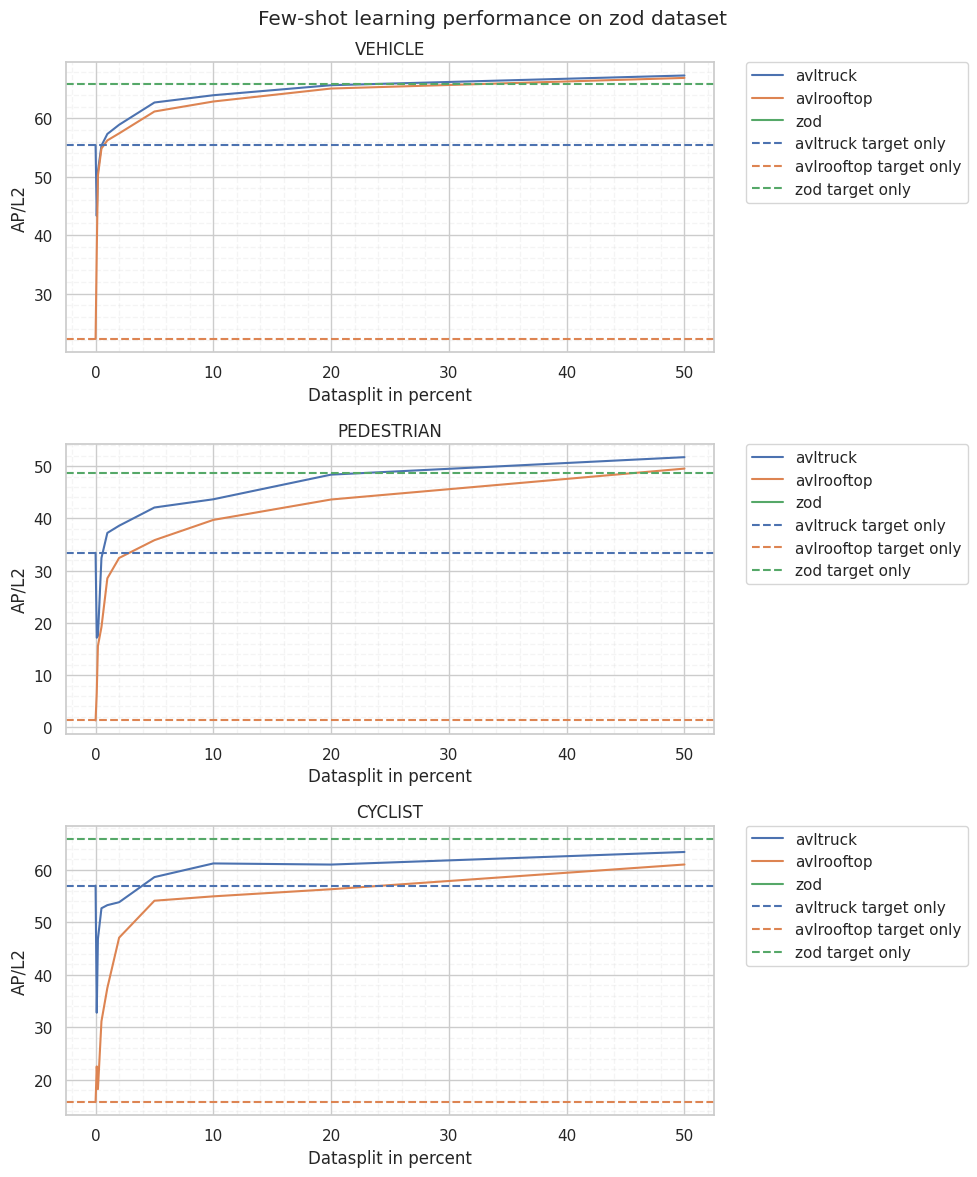

In [11]:
clss_names = ["VEHICLE", "PEDESTRIAN", "CYCLIST"]
target_datasts = ["avltruck", "avlrooftop", "zod"]
#lineplot for each class, difficulty 2
sns.set_theme(style="whitegrid")
for target_dataset in target_datasts:
    fig, axs = plt.subplots(3, 1, figsize=(10, 12))
    for clss in clss_names:
        ax = axs[clss_names.index(clss)]
        plot_results(results_df.copy(), metric="AP", difficulty="2", clss=clss, target_dataset=target_dataset, draw_baseline=True, target_baseline_only=False, baseline_df=baseline_df, ax=ax)
    #plt.xscale('log')
    plt.suptitle("Few-shot learning performance on "+target_dataset+" dataset")
    plt.tight_layout()
    plt.show()


In [82]:
baseline_df

,class,difficulty,metric,value,target_dataset,source_dataset
0,VEHICLE,1,AP,67.8706,avlrooftop,avltruck
1,VEHICLE,2,AP,63.1544,avlrooftop,avltruck
